# Summary

1. [Solve Dependencies](#solve-dependencies)
2. [Create Labels CSV File](#create-labels-csv-file)
3. [Data Split](#data-split)

# Solve Dependencies
<a id="solve-dependencies"></a>


In [25]:
import os
from collections import Counter

import numpy as np
import pandas as pd
import typing as tp
from PIL import Image

from torch.utils.data import DataLoader
import torchvision.models as models

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import pytorch_lightning as pl

pl.seed_everything(seed=42, workers=True)


Seed set to 42


42

# Create CSV File to Store Filenames and Labels
<a id="create-labels-csv-file"></a>


In [26]:
def create_label_csv(root_dir, output_csv):
    # Initialize an empty list to hold the data
    data = []

    # Define class names and their corresponding labels
    class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

    # Loop through each class folder
    for class_name in class_names:
        class_folder = os.path.join(root_dir, class_name)
        
        # Check if the class folder exists
        if not os.path.exists(class_folder):
            print(f"Warning: {class_folder} does not exist.")
            continue
        
        # Loop through all files in the class folder
        for filename in os.listdir(class_folder):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Add any other image formats if needed
                # Create a tuple of (filename, label)
                data.append((class_name+'/'+filename, class_name))
    
    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=['filename', 'label'])
    
    # Save the DataFrame to a CSV file
    df.to_csv(output_csv, index=False)
    print(f"CSV file created at: {output_csv}")

In [27]:
# Specify the directory and the output CSV file name
root_directory = 'data/train'  # Path to the train directory
output_csv_file = 'data/train.csv'  # Output CSV file name

create_label_csv(root_directory, output_csv_file)


CSV file created at: data/train.csv


# Data Split
<a id="data-split"></a>


### Dataset Class

In [28]:
class_map = {
    'CNV': 0,
    'DME': 1,
    'DRUSEN': 2,
    'NORMAL': 3
}

class OCTDataset(Dataset):
    def __init__(
        self,
        images_dir: str,
        labels_csv: str,
        indices: tp.Optional[tp.List[int]] = None,
        transform: tp.Optional[transforms.Compose] = None,
    ):
        self.images_dir = images_dir
        self.labels_csv = labels_csv
        self.transform = transform
        
        # Carrega o arquivo CSV e filtra pelos índices, se fornecidos
        labels_df = pd.read_csv(labels_csv)
        
        if indices is not None:
            # Seleciona apenas os índices fornecidos
            labels_df = labels_df.iloc[indices].reset_index(drop=True)
        
        # Armazena os caminhos das imagens e rótulos como listas
        self.image_paths = [os.path.join(images_dir, fname) for fname in labels_df['filename']]
        self.labels = labels_df['label'].tolist()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Carrega a imagem a partir do caminho
        image = Image.open(self.image_paths[idx]).convert("L")
        
        # Aplica as transformações, se existirem
        if self.transform:
            image = self.transform(image)
        
        # Retorna a imagem e o rótulo
        label = torch.tensor(class_map[self.labels[idx]])
        return image, label

### Split Function

In [29]:
def create_split_datasets(dataset, split_ratio=0.8):
    # Divide o dataset em duas partes principais
    bigger_part_indices, smaller_part_indices = train_test_split(
        range(len(dataset)),
        test_size=(1 - split_ratio),
        stratify=dataset.labels
    )

    # Divide a parte maior em treino e validação
    bigger_train_indices, bigger_val_indices = train_test_split(
        bigger_part_indices,
        test_size=0.4,
        stratify=np.array(dataset.labels)[bigger_part_indices]
    )

    # Divide a parte menor em treino e validação
    smaller_train_indices, smaller_val_indices = train_test_split(
        smaller_part_indices,
        test_size=0.2,
        stratify=np.array(dataset.labels)[smaller_part_indices]
    )

    # Cria os datasets de treino e validação
    bigger_train_dataset = OCTDataset(
        images_dir=dataset.images_dir,
        labels_csv=dataset.labels_csv,
        indices=bigger_train_indices,
        transform=dataset.transform
    )

    bigger_val_dataset = OCTDataset(
        images_dir=dataset.images_dir,
        labels_csv=dataset.labels_csv,
        indices=bigger_val_indices,
        transform=dataset.transform
    )

    # Criar os datasets de treino e validação
    smaller_train_dataset = OCTDataset(
        images_dir=dataset.images_dir,
        labels_csv=dataset.labels_csv,
        indices=smaller_train_indices,
        transform=dataset.transform
    )

    smaller_val_dataset = OCTDataset(
        images_dir=dataset.images_dir,
        labels_csv=dataset.labels_csv,
        indices=smaller_val_indices,
        transform=dataset.transform
    )
    
    return bigger_train_dataset, bigger_val_dataset, smaller_train_dataset, smaller_val_dataset


### Split

In [30]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for SqueezeNet
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(           # Normalize the images
        mean=[0.5],
        std=[0.5]
    )
])

# Instantiate the dataset
root_dir = 'data/train'  # Replace with the actual path to your dataset root
dataset = OCTDataset(
    images_dir=root_dir,
    labels_csv='data/train.csv',
    transform=transform
)

# Dividir o conjunto de treino em auto-supervisão e downstream
self_supervised_train, self_supervised_val, supervised_train, supervised_val = create_split_datasets(
    dataset, split_ratio=0.9)

In [31]:
# Check the size training dataset
print("Train:", len(dataset))

# Check the size of each dataset
print("Self-Supervised Train:", len(self_supervised_train))
print("Self-Supervised Validation:", len(self_supervised_val))
print("Downstream Train:", len(supervised_train))
print("Downstream Validation:", len(supervised_val))

Train: 108309
Self-Supervised Train: 58486
Self-Supervised Validation: 38992
Downstream Train: 8664
Downstream Validation: 2167


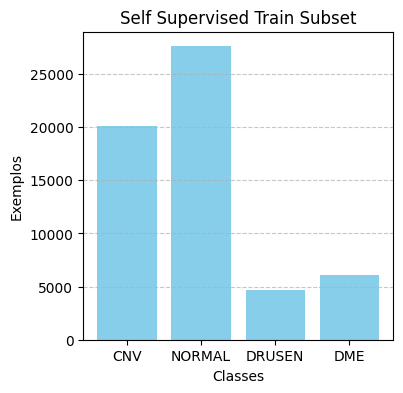

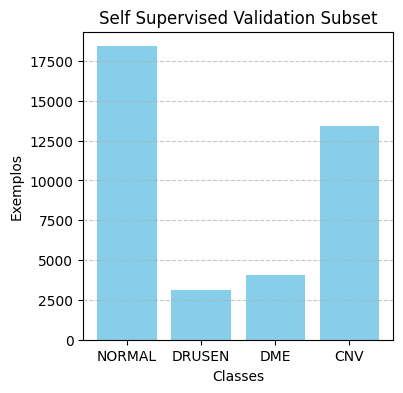

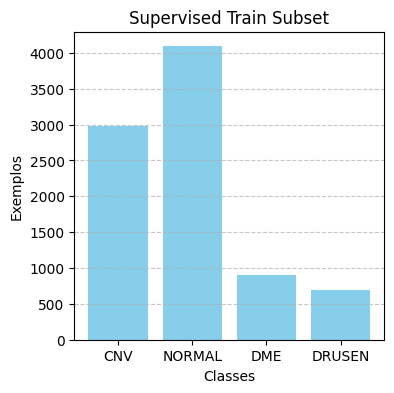

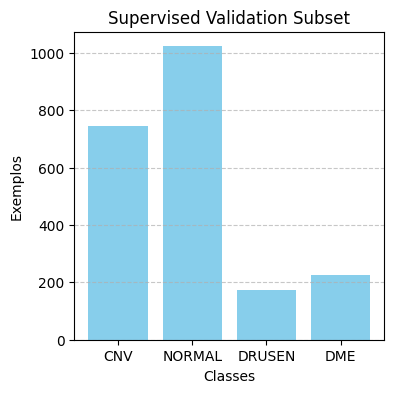

In [32]:
def plot_class_distribution(dataset, dataset_name):
    labels = np.array(dataset.labels)  # Obtém os rótulos do dataset
    
    class_counts = Counter(labels)  # Conta os exemplos por classe

    # Tamanho do gráfico
    plt.figure(figsize=(4, 4))  # Ajusta o tamanho do gráfico (largura, altura)
    
    # Gráfico de barras
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Exemplos")
    plt.title(f"{dataset_name}")

    # Mostra a grade para melhor visualização
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

# Plotar distribuições para cada conjunto
plot_class_distribution(self_supervised_train, "Self Supervised Train Subset")
plot_class_distribution(self_supervised_val, "Self Supervised Validation Subset")
plot_class_distribution(supervised_train, "Supervised Train Subset")
plot_class_distribution(supervised_val, "Supervised Validation Subset")

In [36]:

# Define o dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Caminho para salvar checkpoints
CHECKPOINT_PATH = "checkpoints"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

def save_checkpoint(epoch, model, optimizer, losses, accuracies, filename):
    """Salva um checkpoint contendo modelo, otimizador e métricas."""
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "losses": losses,
        "accuracies": accuracies,
    }
    torch.save(checkpoint, filename)

def load_checkpoint(filename, model, optimizer):
    """Carrega um checkpoint."""
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        epoch = checkpoint["epoch"]
        losses = checkpoint["losses"]
        accuracies = checkpoint["accuracies"]
        print(f"Checkpoint carregado de {filename}, retomando do epoch {epoch+1}")
        return epoch, losses, accuracies
    else:
        print(f"Nenhum checkpoint encontrado em {filename}, iniciando do zero.")
        return 0, {"train": [], "val": []}, {"train": [], "val": []}

def baseline_work(batch_size, lr, num_epochs):
    # Carrega o modelo pré-treinado SqueezeNet
    model = models.squeezenet1_1(pretrained=True)

    # Modifica a primeira camada para aceitar imagens de um canal
    model.features[0] = nn.Conv2d(
        in_channels=1,  # Aceitar 1 canal
        out_channels=64,
        kernel_size=(3, 3),
        stride=(2, 2),
        padding=(1, 1),
        bias=False
    )

    # Ajusta o classificador para 4 classes
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Conv2d(512, 4, kernel_size=(1, 1)),
        nn.ReLU(inplace=True),
        nn.AdaptiveAvgPool2d((1, 1))
    )

    # Movendo para o dispositivo
    model = model.to(device)

    # Define o critério e otimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr)

    # Transformação das imagens
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # Carrega os dados (substitua supervised_train/val pelos seus datasets)
    # Exemplo:
    # supervised_train = SeuDataset(transform=transform, ...)
    # supervised_val = SeuDataset(transform=transform, ...)
    train_loader = DataLoader(supervised_train, batch_size, shuffle=True)
    val_loader = DataLoader(supervised_val, batch_size, shuffle=False)

    # Checkpoints
    checkpoint_file = os.path.join(CHECKPOINT_PATH, "last_checkpoint.pth")
    start_epoch, losses, accuracies = load_checkpoint(checkpoint_file, model, optimizer)

    # Treinamento e validação
    for epoch in range(start_epoch, num_epochs):
        # Modo de treino
        model.train()
        running_loss_train = 0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss_train += loss.item() * images.size(0)

            # Cálculo da acurácia de treino
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss_train / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        losses["train"].append(train_loss)
        accuracies["train"].append(train_accuracy)

        # Modo de validação (teste)
        model.eval()
        running_loss_val = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item() * images.size(0)

                # Cálculo da acurácia de validação
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_loss_val / len(val_loader.dataset)
        val_accuracy = 100 * correct_val / total_val
        losses["val"].append(val_loss)
        accuracies["val"].append(val_accuracy)

        # Exibe métricas por época
        print(f"Época {epoch+1}/{num_epochs}, Loss Treino: {train_loss}, Acurácia Treino: {train_accuracy}")
        print(f"Época {epoch+1}/{num_epochs}, Loss Validação: {val_loss}, Acurácia Validação: {val_accuracy}")

        # Salvar checkpoint
        save_checkpoint(epoch, model, optimizer, losses, accuracies, checkpoint_file)

    # Salva o modelo final e os resultados
    torch.save(model.state_dict(), "modelo_squeezenet.pth")
    torch.save({
        "train_loss": losses["train"],
        "train_accuracy": accuracies["train"],
        "val_loss": losses["val"],
        "val_accuracy": accuracies["val"]
    }, "treinamento_histórico.pth")

base = baseline_work(batch_size=32, lr=1e-5, num_epochs=30)


Nenhum checkpoint encontrado em checkpoints/last_checkpoint.pth, iniciando do zero.
Época 1/30, Loss Treino: 0.9894982927503788, Acurácia Treino: 62.39612188365651
Época 1/30, Loss Validação: 0.6696827591538265, Acurácia Validação: 75.8191047531149
Época 2/30, Loss Treino: 0.6272182490741998, Acurácia Treino: 77.72391505078485
Época 2/30, Loss Validação: 0.5307055457869487, Acurácia Validação: 81.31056760498385
Época 3/30, Loss Treino: 0.5365580279080822, Acurácia Treino: 81.35964912280701
Época 3/30, Loss Validação: 0.487224406479799, Acurácia Validação: 82.55652976465159
Época 4/30, Loss Treino: 0.4892285479678121, Acurácia Treino: 82.77931671283471
Época 4/30, Loss Validação: 0.45684131629245867, Acurácia Validação: 83.66405168435625
Época 5/30, Loss Treino: 0.45873589484865535, Acurácia Treino: 84.07202216066482
Época 5/30, Loss Validação: 0.4619540268779626, Acurácia Validação: 83.75634517766497
Época 6/30, Loss Treino: 0.42866720965034083, Acurácia Treino: 85.19159741458911
Época

/tmp/ipykernel_9993/845945504.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  historico = torch.load(historico_path)


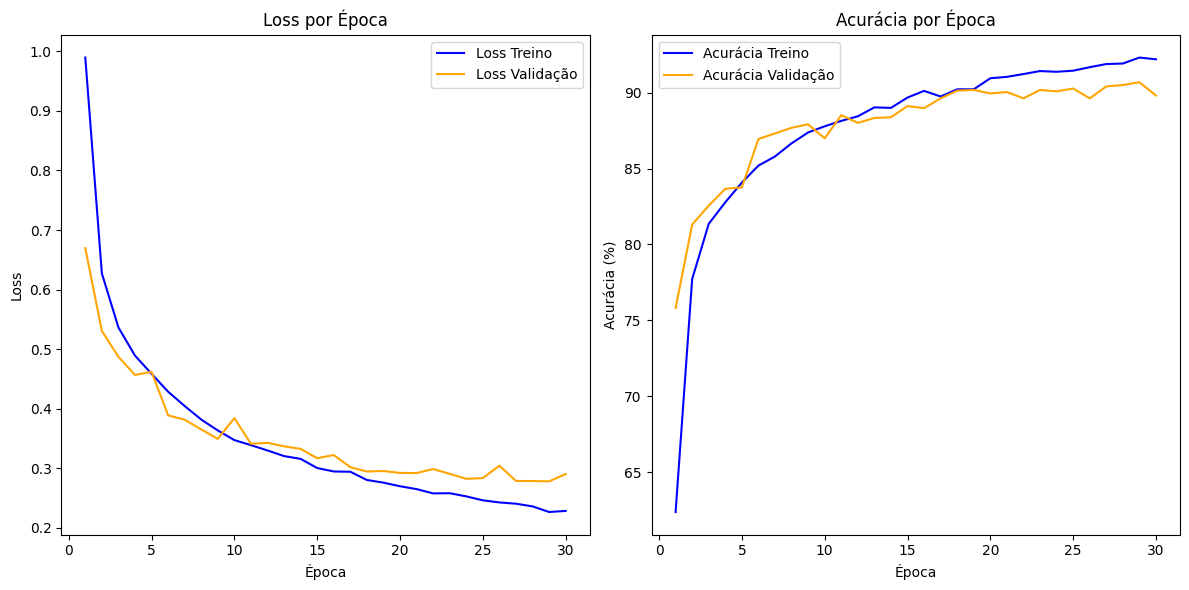

In [37]:
# Carregar os dados do histórico
historico_path = "treinamento_histórico.pth"
historico = torch.load(historico_path)

# Extrair os dados
train_losses = historico["train_loss"]
train_accuracies = historico["train_accuracy"]
val_losses = historico["val_loss"]
val_accuracies = historico["val_accuracy"]

# Número de épocas (com base nos dados carregados)
num_epochs = len(train_losses)

# Gráficos de métricas
plt.figure(figsize=(12, 6))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Loss Treino", color="blue")
plt.plot(range(1, num_epochs + 1), val_losses, label="Loss Validação", color="orange")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Loss por Época")
plt.legend()

# Gráfico de Acurácia
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Acurácia Treino", color="blue")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Acurácia Validação", color="orange")
plt.xlabel("Época")
plt.ylabel("Acurácia (%)")
plt.title("Acurácia por Época")
plt.legend()

plt.tight_layout()
plt.show()